In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer

import shap

#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

# XAI methods
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = load_and_info('data/df_investig_INR.csv')

columnas_a_eliminar = ['Unnamed: 0']

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=columnas_a_eliminar)


,Column,Dtype,Missing,Unique,Sample values
0,Unnamed: 0,int64,0,133,"[0, 1, 2, 3, 4]"
1,INR,float64,0,75,"[4.3, 2.8, 2.12, 2.77, 2.36]"
2,CALCI,float64,0,53,"[7.52, 8.54, 2.21, 8.96, 9.12]"
3,HEMOGLOBINA,float64,0,93,"[10.3, 12.24, 8.7, 13.3, 14.0]"
4,VCM,float64,0,105,"[95.7, 103.26, 86.4, 80.6, 95.5]"
5,HEMATOCRIT,float64,0,108,"[31.8, 36.65, 43.2, 40.25, 41.93]"
6,PLAQUETES,float64,0,101,"[192.0, 177.36, 220.0, 200.0, 168.33]"
7,DIAGNOSTIC_ASSOCIAT,object,0,20,"[FA_NE, Flutter_NE, Valv_Aort_NReum_NE, EP_Oth..."
8,IMC,float64,0,106,"[27.33, 19.751666666666665, 27.425, 24.94, 34.13]"
9,HB_GLICOSILADA_A1C,float64,0,21,"[6.22, 8.0, 6.2, 6.3, 6.5]"



El juego de datos contiene 21 variables y 133 observaciones, de las cuales 0 son duplicadas.


In [4]:
# Store in different lists the names of the categorical and numerical columns since they will be treated different 
categorical = df.select_dtypes(include=['object']).columns.tolist()  # for strings 
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist() # for numbers

In [5]:
categorical

['DIAGNOSTIC_ASSOCIAT']

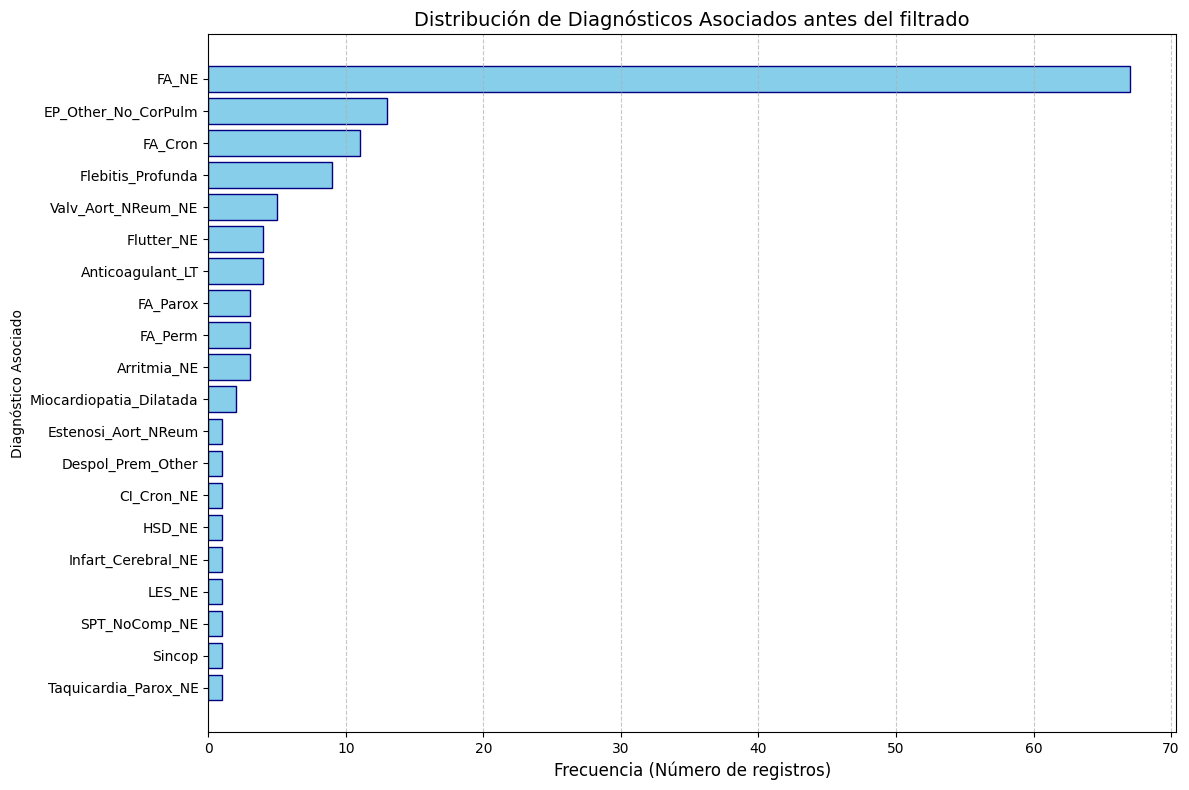

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preparación de los datos de ejemplo (basado en tu descripción)
# Suponiendo que 'df' es tu DataFrame original
# Creamos variables dummies para la columna 'DIAGNÒSTIC_ASSOCIAT'
df_X_train_cat = pd.get_dummies(df['DIAGNOSTIC_ASSOCIAT'])
categorical_update = df_X_train_cat.columns.tolist()

# 2. Cálculo de frecuencias (tu lógica original)
freq_analysis = pd.DataFrame({
    'Variable': categorical_update,
    'Frecuencia': [df_X_train_cat[col].sum() for col in df_X_train_cat],
    'Porcentaje': [(df_X_train_cat[col].sum() / len(df_X_train_cat)) * 100 for col in categorical_update]
}).sort_values('Frecuencia', ascending=False)

# 3. Visualización de frecuencias
plt.figure(figsize=(12, 8))
plt.barh(freq_analysis['Variable'], freq_analysis['Frecuencia'], color='skyblue', edgecolor='navy')
plt.xlabel('Frecuencia (Número de registros)', fontsize=12)
plt.ylabel('Diagnóstico Asociado', fontsize=10)
plt.title('Distribución de Diagnósticos Asociados antes del filtrado', fontsize=14)
plt.gca().invert_yaxis()  # Invertir para que la más frecuente esté arriba
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df_filtrado = df[df['DIAGNOSTIC_ASSOCIAT'].isin(['FA_NE', 'EP_Other_No_CorPulm','FA_Cron', 'Flebitis_Profunda'])].copy()

### 2.2 División de los datos en conjuntos de datos de entrenamiento, validación y prueba

In [7]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df_filtrado.copy() 
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64','float64']).columns.tolist()
numerical.remove('INR')

In [8]:
numerical

['CALCI',
 'HEMOGLOBINA',
 'VCM',
 'HEMATOCRIT',
 'PLAQUETES',
 'IMC',
 'HB_GLICOSILADA_A1C',
 'PES',
 'CRIBRATGE_ALIMENTACIO',
 'MAGNESI',
 'CLORUR',
 'CBPAAT',
 'VALORACIO_AUDIT_C',
 'NT_PROBNP',
 'CREATINA_KINASA_CK',
 'FREQ_CARDIACA',
 'PCR',
 'HEMATIES']

In [9]:
# first separate the train from the test set
df_train, df_test = train_test_split(df_select, test_size=0.2, random_state=1)
len(df_train), len(df_test)

(80, 20)

In [10]:
# reset index
df_train = df_train.reset_index(drop=True)
# define the target
y_train = df_train.INR.values
# remove the target from the features
del df_train['INR']

### 2.3 Codificación y normalización de las 'features'

In [11]:
from sklearn.feature_extraction import DictVectorizer 

dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
train_dict = df_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_train_cat = dv.fit_transform(train_dict) # make it a vector

df_X_train_cat = pd.DataFrame(X_train_cat,columns= dv.get_feature_names_out())

categorical_update = df_X_train_cat.columns.to_list()


In [12]:
# TRAIN
X_train_num = df_train[numerical].values
#X_train_num = scaler.fit_transform(X_train_num)

Se unen las matrices numéricas y categóricas

In [13]:
# TRAIN
X_train = np.column_stack([X_train_num, X_train_cat])


Las nuevas caracteristicas son:

In [14]:
feature_names = numerical + categorical_update
feature_names

df_X_train = pd.DataFrame(X_train, columns=feature_names)

El análisis de frecuencia de los diagnósticos asociados proporciona una explicación técnica de por qué estas variables presentan una importancia mínima en el modelo LightGBM actual pues la distribución de los datos muestra que la Fibrilación Auricular (FA_NE) es la indicación predominante representando más del 52% de los diagnósticos registrados lo que sitúa a esta patología como el contexto clínico base del estudio. Sin embargo la mayoría de las 17 variables identificadas poseen frecuencias extremadamente bajas con un elevado número de categorías que cuentan con un solo registro lo que impide que el algoritmo identifique relaciones causales o patrones consistentes con el valor de INR debido a la falta de potencia estadística para cada etiqueta individual. Esta fragmentación de la información justifica que en el gráfico de importancia de permutación todas las variables que comienzan por el prefijo de diagnóstico aparezcan en la zona de impacto nulo o residual ya que el modelo prioriza variables continuas con mayor densidad y variabilidad como el IMC o los parámetros de función renal que ofrecen una señal predictiva mucho más estable y robusta. Desde la perspectiva de la explicabilidad (XAI) el hecho de que estas variables no destaquen confirma que el modelo no está sobreajustando a casos clínicos aislados sino que busca factores metabólicos generales para explicar la variabilidad del INR en una muestra de tamaño limitado como es N=133.

### 3. Aplicación del modelo de aprendizaje automático: Random forest

Entrenamos el modelo ganador con los datos de entrenamiento: 

In [15]:

rf_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    max_features=1.0,
    max_depth=None,      
    random_state=23,
    n_jobs=-1
)

model = rf_model.fit(X_train, y_train)

In [16]:
# preparation TEST data

# reset index after the splitting shuffling
df_test = df_test.reset_index(drop=True)
# define target of the test set
y_test = df_test.INR.values
df_test.info()
# 1. encode the categorical features and remove redundant columns-------------    
test_dict = df_test[categorical].to_dict(orient='records')

X_test_cat = dv.transform(test_dict) 

# convert the data array to a dataframe
df_X_test_cat = pd.DataFrame(X_test_cat,columns= dv.get_feature_names_out())

df_X_test_cat.info()
# convert the dataframe to a np.array again
X_test_cat = df_X_test_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------

# Unificar características numéricas y categóricas del test en un solo DataFrame
df_X_test_final = pd.concat([df_test[numerical].reset_index(drop=True), df_X_test_cat], axis=1)

# Asegúrate de que df_X_test_final tiene el mismo orden de columnas que df_X_train
# Esto es crítico: usar las columnas del training set para el test set
df_X_test = df_X_test_final[df_X_train.columns] # Asumo que df_X_train es el DataFrame de features de entrenamiento

# Convierte a array para el modelo
X_test = df_X_test.to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   INR                    20 non-null     float64
 1   CALCI                  20 non-null     float64
 2   HEMOGLOBINA            20 non-null     float64
 3   VCM                    20 non-null     float64
 4   HEMATOCRIT             20 non-null     float64
 5   PLAQUETES              20 non-null     float64
 6   DIAGNOSTIC_ASSOCIAT    20 non-null     object 
 7   IMC                    20 non-null     float64
 8   HB_GLICOSILADA_A1C     20 non-null     float64
 9   PES                    20 non-null     float64
 10  CRIBRATGE_ALIMENTACIO  20 non-null     float64
 11  MAGNESI                20 non-null     float64
 12  CLORUR                 20 non-null     float64
 13  CBPAAT                 20 non-null     float64
 14  VALORACIO_AUDIT_C      20 non-null     float64
 15  NT_PROBN

In [17]:
# model application on TEST data
y_pred = rf_model.predict(X_test)

r2_test_score = r2_score(y_test, y_pred)

print(f"El R2 score del modelo en el conjunto de prueba completo es: {r2_test_score:.4f}")
# metrics analysis

evaluate_model(y_test, y_pred,'LGBM')

El R2 score del modelo en el conjunto de prueba completo es: -0.2139
--- Evaluación: LGBM ---
R² (Coeficiente de Determinación): -0.2139
RMSE (Error Cuadrático Medio): 0.3041
MAE (Error Absoluto Medio): 0.2585


{'R2': -0.21391420318081322,
 'RMSE': 0.304110617183178,
 'MAE': 0.25845975799723553}

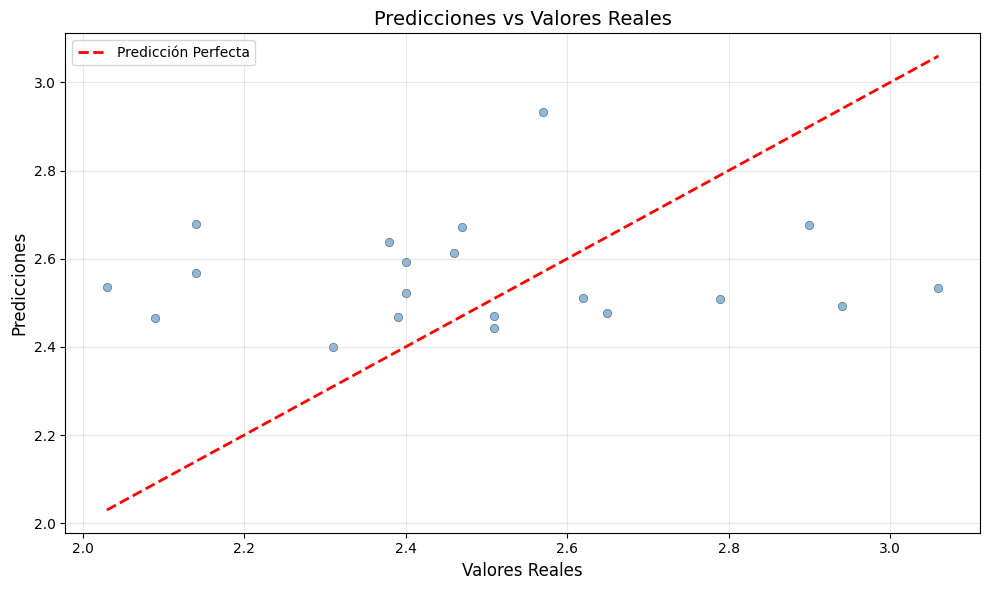

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Predicción Perfecta')
plt.xlabel('Valores Reales', fontsize=12)
plt.ylabel('Predicciones', fontsize=12)
plt.title('Predicciones vs Valores Reales', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

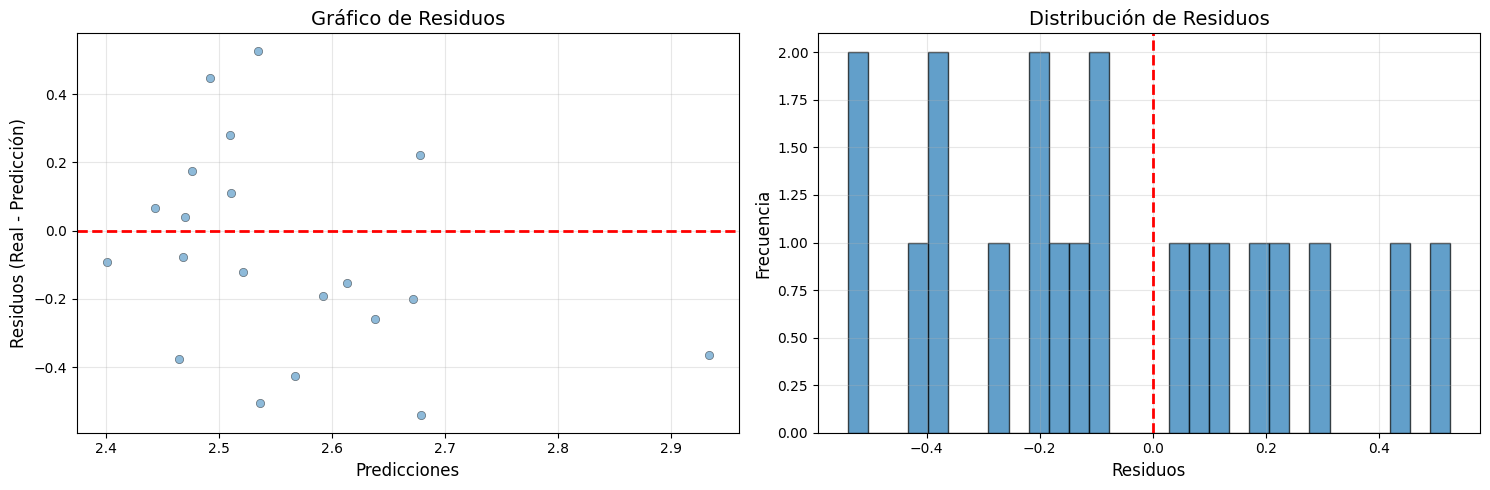

In [19]:
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 2a. Residuos vs Predicciones
axes[0].scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicciones', fontsize=12)
axes[0].set_ylabel('Residuos (Real - Predicción)', fontsize=12)
axes[0].set_title('Gráfico de Residuos', fontsize=14)
axes[0].grid(alpha=0.3)

# 2b. Distribución de Residuos
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residuos', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Residuos', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

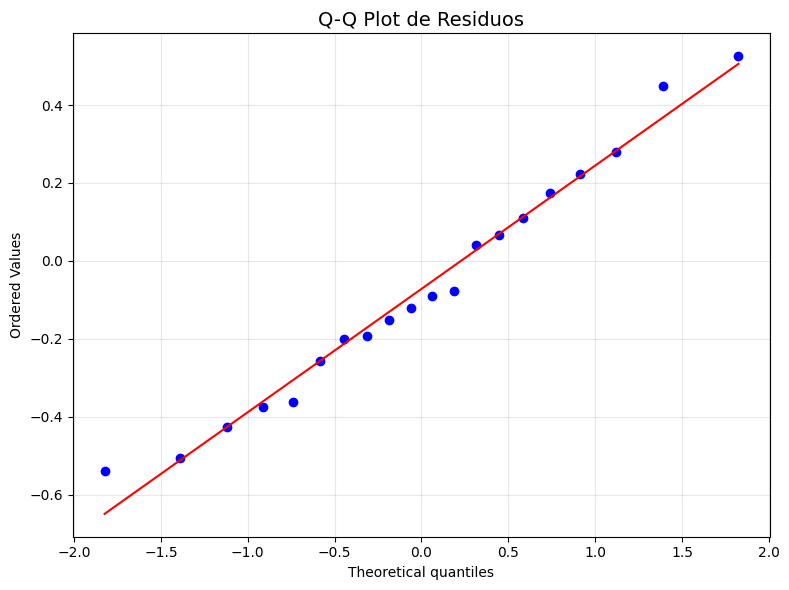

In [20]:
from scipy import stats

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("=" * 50)
print("MÉTRICAS DE EVALUACIÓN")
print("=" * 50)
print(f"MSE (Mean Squared Error):     {mse:.6f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"MAE (Mean Absolute Error):    {mae:.6f}")
print(f"R² Score:                     {r2:.6f}")
print(f"MAPE (Mean Absolute % Error): {mape:.2f}%")
print("=" * 50)

MÉTRICAS DE EVALUACIÓN
MSE (Mean Squared Error):     0.092483
RMSE (Root Mean Squared Error): 0.304111
MAE (Mean Absolute Error):    0.258460
R² Score:                     -0.213914
MAPE (Mean Absolute % Error): 10.63%


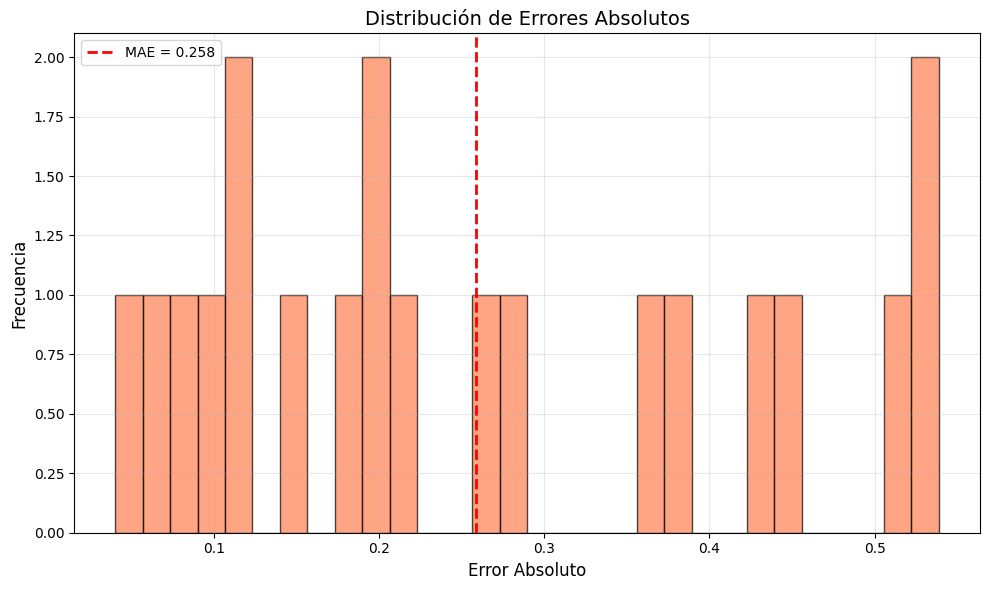

In [22]:
absolute_errors = np.abs(residuals)

plt.figure(figsize=(10, 6))
plt.hist(absolute_errors, bins=30, edgecolor='black', alpha=0.7, color='coral')
plt.axvline(x=mae, color='r', linestyle='--', lw=2, label=f'MAE = {mae:.3f}')
plt.xlabel('Error Absoluto', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de Errores Absolutos', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\VALER\AppData\Local\Temp\ipykernel_8644\3677122995.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([residuals], vert=True, labels=['Residuos'])


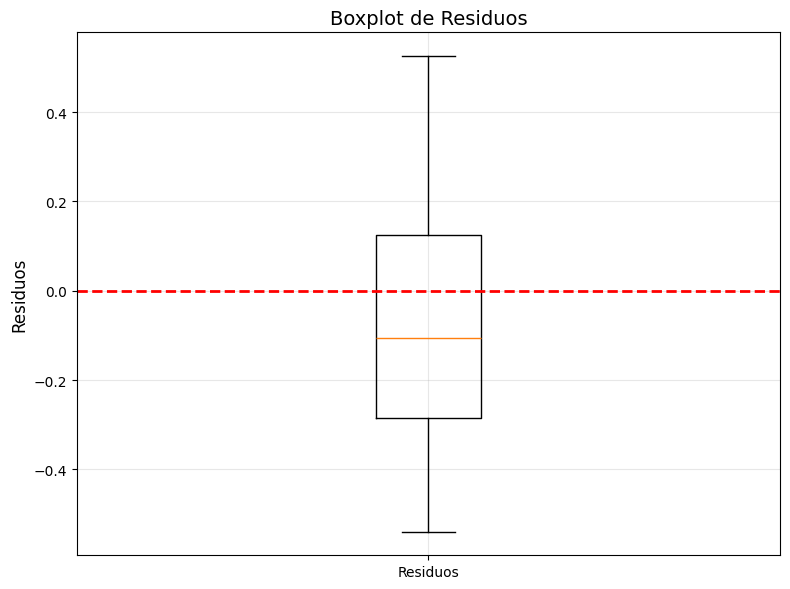

In [23]:
plt.figure(figsize=(8, 6))
plt.boxplot([residuals], vert=True, labels=['Residuos'])
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.ylabel('Residuos', fontsize=12)
plt.title('Boxplot de Residuos', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2.2 Aplicación del light

In [24]:
new_patient = {
  "CALCI": 9.4,
  "HEMOGLOBINA": 13.8,
  "VCM": 90,
  "HEMATOCRIT": 41,
  "PLAQUETES": 220,
  "IMC": 27.5,
  "HB_GLICOSILADA_A1C": 6.1,
  "PES": 82,
  "CRIBRATGE_ALIMENTACIO": 0.2,
  "MAGNESI": 1.9,
  "CLORUR": 102,
  "CBPAAT": 125,
  "VALORACIO_AUDIT_C": 1,
  "NT_PROBNP": 650,
  "CREATINA_KINASA_CK": 115,
  "FREQ_CARDIACA": 85,
  "PCR": 0.4,
  "HEMATIES": 4.7,
  "DIAGNOSTIC_ASSOCIAT=FA_NE": 1,
  "DIAGNOSTIC_ASSOCIAT=EP_Other_No_CorPulm":0,
  "DIAGNOSTIC_ASSOCIAT=FA_Cron":0,
  "DIAGNOSTIC_ASSOCIAT=Flebitis_Profunda":0,
 }

In [25]:
num_dict = dict()
cat_dict = dict()
    
for (key, value) in new_patient.items():
    if key in numerical:
        num_dict[key] = value
    else:
        cat_dict[key] = value

# DictVect input must be a dict
X_cat = dv.transform(cat_dict) # encode the categorical features
df_X_cat = pd.DataFrame(X_cat,columns= dv.get_feature_names_out()) # convert array to df

df_X_cat.info()

X_cat = df_X_cat.to_numpy() # convert the dataframe to a np.array again

# Scaler input must be a np.array
X_num = np.array(list(num_dict.values())).reshape(1, -1)
#X_num = scaler.transform(X_num) # scale the numerical features

# Join both arrays
X = np.column_stack([X_num, X_cat]) 

print(feature_names)
# Convert to DataFrame with correct column names
df_X = pd.DataFrame(X, columns=feature_names)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   DIAGNOSTIC_ASSOCIAT=EP_Other_No_CorPulm  1 non-null      float64
 1   DIAGNOSTIC_ASSOCIAT=FA_Cron              1 non-null      float64
 2   DIAGNOSTIC_ASSOCIAT=FA_NE                1 non-null      float64
 3   DIAGNOSTIC_ASSOCIAT=Flebitis_Profunda    1 non-null      float64
dtypes: float64(4)
memory usage: 160.0 bytes
['CALCI', 'HEMOGLOBINA', 'VCM', 'HEMATOCRIT', 'PLAQUETES', 'IMC', 'HB_GLICOSILADA_A1C', 'PES', 'CRIBRATGE_ALIMENTACIO', 'MAGNESI', 'CLORUR', 'CBPAAT', 'VALORACIO_AUDIT_C', 'NT_PROBNP', 'CREATINA_KINASA_CK', 'FREQ_CARDIACA', 'PCR', 'HEMATIES', 'DIAGNOSTIC_ASSOCIAT=EP_Other_No_CorPulm', 'DIAGNOSTIC_ASSOCIAT=FA_Cron', 'DIAGNOSTIC_ASSOCIAT=FA_NE', 'DIAGNOSTIC_ASSOCIAT=Flebitis_Profunda']


In [26]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Necesitas conocer el valor real para ese paciente.
# Debes reemplazar 'valor_real_conocido' con el valor correcto.
y_true_paciente = 2.5

y_pred_paciente = rf_model.predict(X)[0] # Tomamos la predicción

# --- Métricas para un solo punto ---

# A. Error Absoluto
error_absoluto = np.abs(y_true_paciente - y_pred_paciente)

# B. Error Cuadrático (útil si tu modelo se entrenó con MSE/RMSE)
mse_paciente = mean_squared_error([y_true_paciente], [y_pred_paciente])
rmse_paciente = np.sqrt(mse_paciente)

print(f"Predicción del INR (y_pred): {y_pred_paciente:.2f}")
print(f"Valor Real del INR (y_true): {y_true_paciente:.2f}")
print("---")
print(f"Error Absoluto para este paciente: {error_absoluto:.4f}")
print(f"RMSE para este paciente: {rmse_paciente:.4f}")

Predicción del INR (y_pred): 2.44
Valor Real del INR (y_true): 2.50
---
Error Absoluto para este paciente: 0.0553
RMSE para este paciente: 0.0553


# 4. Aplicación de métodos de explicabilidad

## Métodos intrínsecos del modelo

### Gini Importance (Mean Decrease Impurity)


--- Top 10 Características por Gini Importance (MDI) ---


FREQ_CARDIACA                0.227092
HEMATIES                     0.169050
VCM                          0.131004
PCR                          0.109777
HEMOGLOBINA                  0.099533
HEMATOCRIT                   0.057420
IMC                          0.056253
PLAQUETES                    0.051933
PES                          0.044138
DIAGNOSTIC_ASSOCIAT=FA_NE    0.015210
dtype: float64

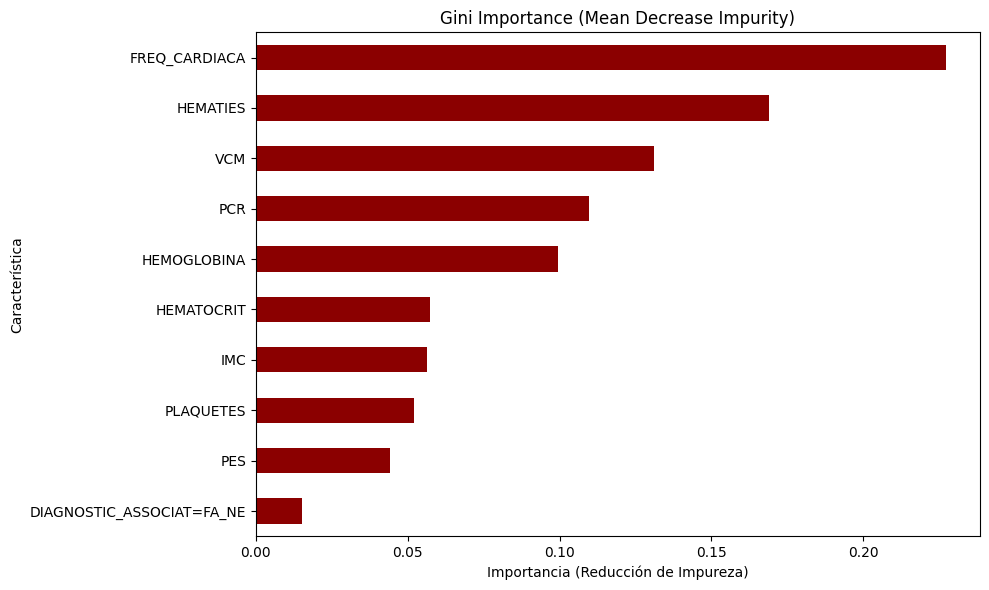

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
# Asumimos que rf_model_regularized es el modelo que dio R² = 0.0508
# Y que X_test_scaled.columns (o X_train_scaled.columns) tiene los nombres limpios de las características.

# 1. Extraer la Gini Importance directamente del modelo ajustado
gini_importances = pd.Series(
    rf_model.feature_importances_,
    index=df_X_train.columns 
).sort_values(ascending=False)

# 2. Mostrar las top 10 características
print("\n--- Top 10 Características por Gini Importance (MDI) ---")
display(gini_importances.head(10))

# 3. Generar el gráfico de barras
plt.figure(figsize=(10, 6))
gini_importances.head(10).plot.barh(color='darkred')
plt.title('Gini Importance (Mean Decrease Impurity)')
plt.xlabel('Importancia (Reducción de Impureza)')
plt.ylabel('Característica')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Métodos de explicabilidad post hoc (Model-Agnostic)
### Permutation Feature Importance


In [28]:
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore', message='X has feature names')

metric = make_scorer(r2_score)

result = permutation_importance(rf_model, df_X_test, y_test, scoring = metric,n_repeats = 10, random_state = 1)
rf_per_importances = pd.Series(result.importances_mean, index=feature_names)


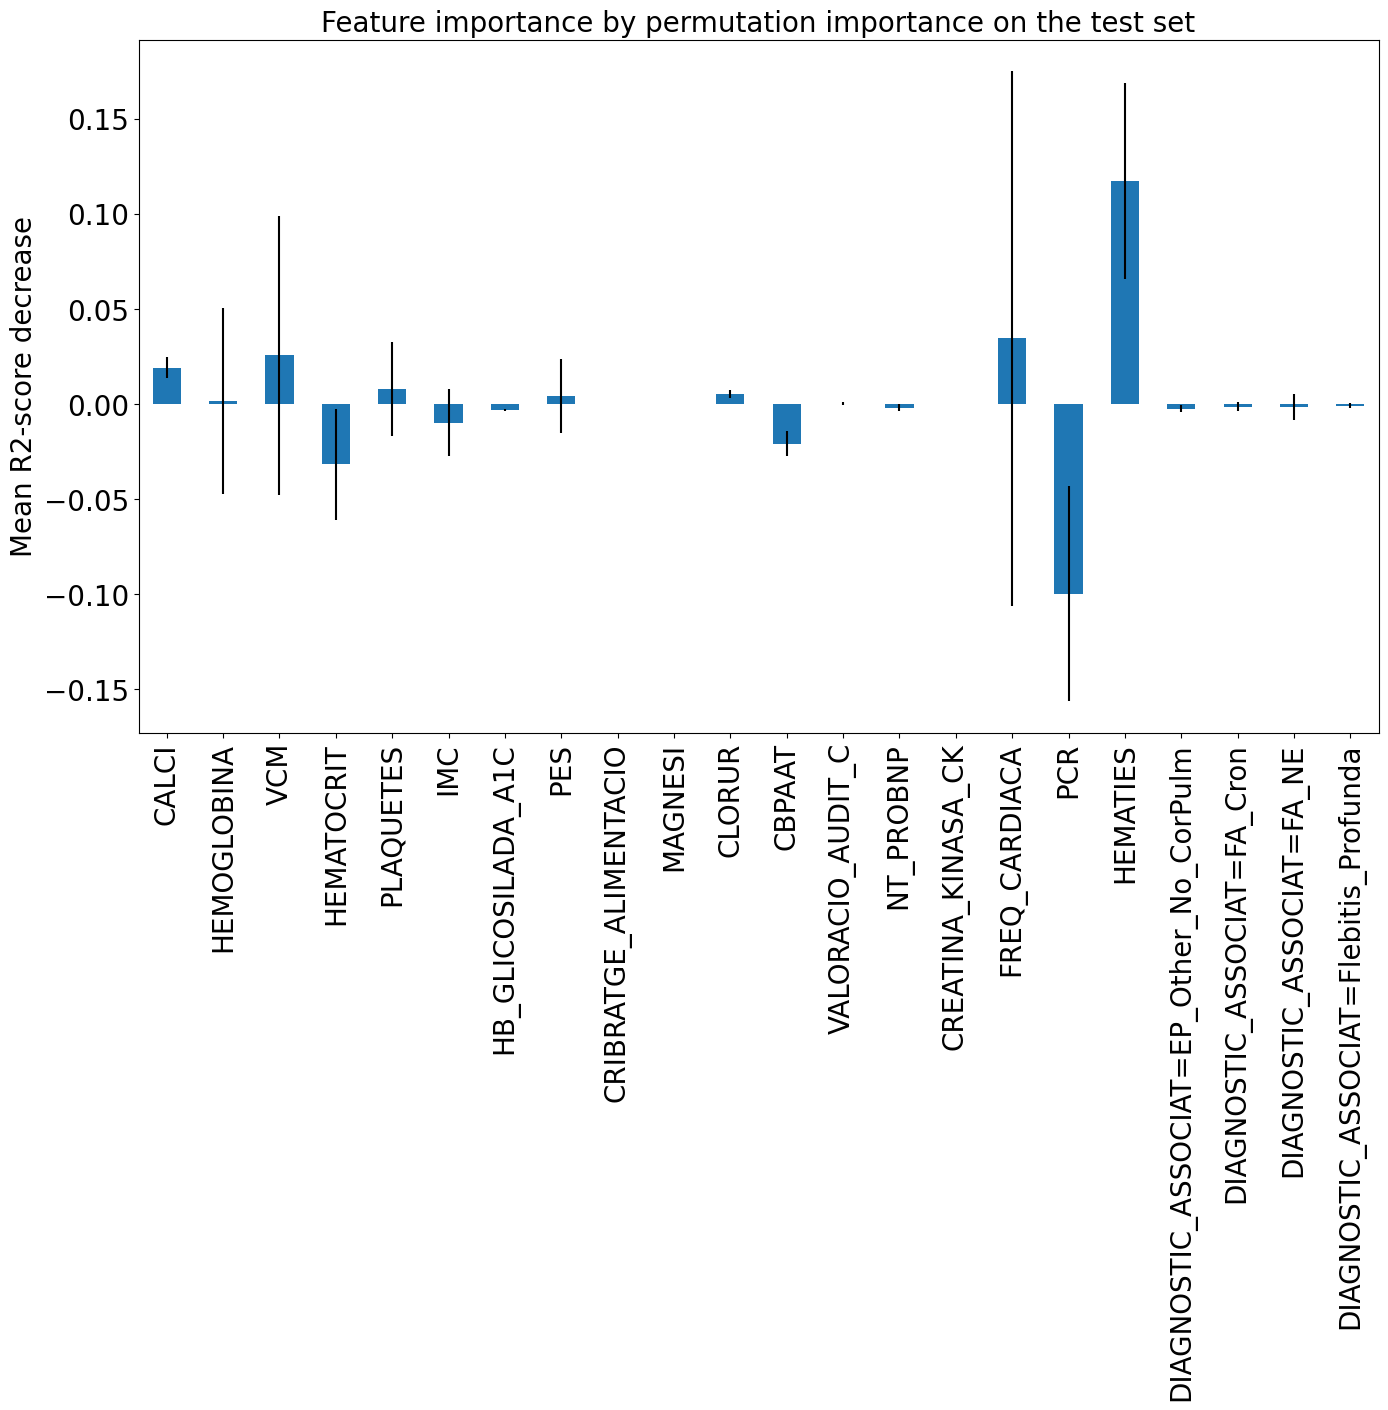

In [29]:
fig, ax = plt.subplots(figsize = (16, 9))
rf_per_importances.plot.bar(yerr=result.importances_std, ax = ax,fontsize = 20)
ax.set_title("Feature importance by permutation importance on the test set",fontsize = 20)
ax.set_ylabel("Mean R2-score decrease",fontsize = 20) # Etiqueta correcta
plt.show()

Estas variables son las que, al ser eliminadas o permutadas, causan la mayor caída en el rendimiento del modelo ($R^2$).HEMAties (Hematíes): Es, con diferencia, la característica más importante. Su permutación causa la mayor caída en el $R^2$ (alrededor de $+0.125$). Esto sugiere que el recuento de glóbulos rojos tiene una relación fuerte y útil con la predicción del INR.VCM (Volumen Corpuscular Medio): Muestra una caída significativa en el $R^2$ (cercana a $+0.025$).CALCI (Calcio): Muestra una pequeña, pero positiva, caída en el $R^2$ (alrededor de $+0.02$).2. Características Inútiles o Engañosas (Impacto Negativo o Cero):Un valor de importancia negativo es una señal crítica. Significa que el modelo funcionaría mejor sin esa característica, ya que la variable solo introduce ruido o que la dependencia del modelo en esa característica es falsa.PCR (Proteína C Reactiva): Esta variable muestra el valor negativo más grande (alrededor de $-0.10$). Esto es muy inusual. Indica que el modelo de Random Forest se apoyó incorrectamente en PCR y que la permutación de esta variable en realidad aumentó el $R^2$ medio.Acción: Considera eliminar PCR de tu conjunto de datos y reentrenar el Random Forest, ya que parece estar empeorando el modelo.La mayoría de las demás variables (ej. IMC, PES, MAGNESI, DIAGNOSTIC_ASSOCIAT_...) tienen valores muy cercanos a cero, lo que significa que no contribuyen significativamente a la predicción del INR en este modelo.🏆 Conclusión y RecomendaciónModelo Ganador: El Random Forest es tu modelo ganador.Variables Clave: HEMAties es la variable principal para la predicción del INR.Filtro: Las variables con importancia cercana a cero o negativa (PCR) deben ser eliminadas para simplificar y posiblemente mejorar el rendimiento (aunque $R^2=0.0508$ es el límite superior probable para la predictibilidad de tus datos).

###  Partial dependence plots

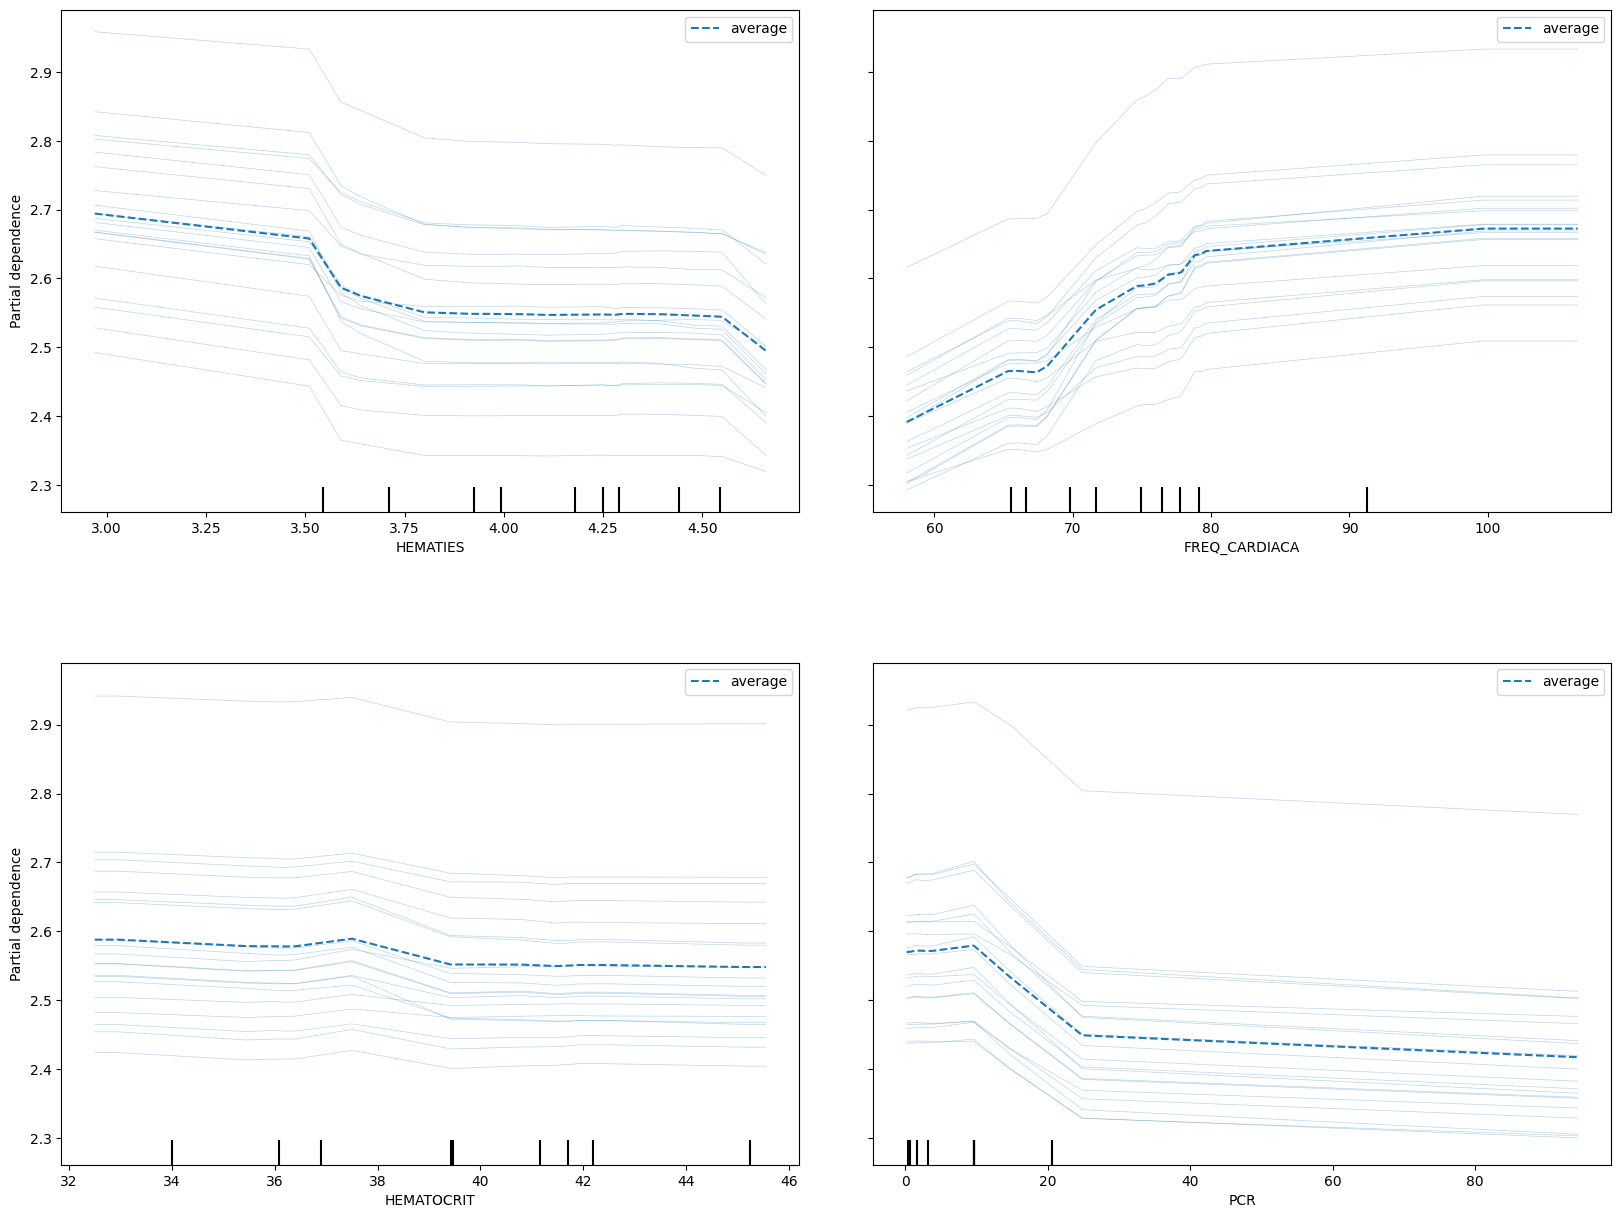

In [30]:
# convert test data from numpy array to dataframe
import warnings
warnings.filterwarnings('ignore', message='X has feature names')

#TEST
df_X_test = pd.DataFrame(X_test,columns=feature_names)

# partial depende plots
fig, ax = plt.subplots(2,2,figsize=(20, 15))

PDD = PartialDependenceDisplay.from_estimator(
    rf_model,
    df_X_test,
    features = ['HEMATIES','FREQ_CARDIACA','HEMATOCRIT', 'PCR'], 
    kind = 'both', subsample = 50, grid_resolution = 100,
    random_state = 1, ax = ax
)

PDD.figure_.subplots_adjust(hspace=0.3, wspace=0.1)

plt.rcParams['font.size'] = '20' #run this cell twice or more times to get the right fontsize

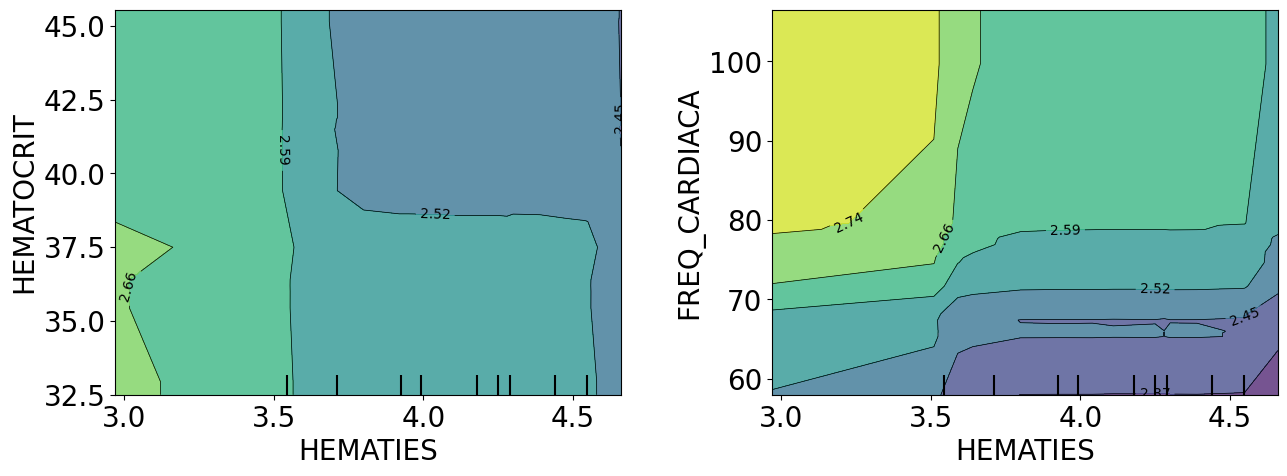

In [31]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))

PDD = PartialDependenceDisplay.from_estimator(
    rf_model,
    df_X_test,
    features = [('HEMATIES','HEMATOCRIT'), ('HEMATIES','FREQ_CARDIACA')],
    kind = 'average', subsample = 50, grid_resolution = 100,
    random_state = 1, ax = ax
)

PDD.figure_.subplots_adjust(hspace=0.3, wspace=0.3)

plt.rcParams['font.size'] = '20' #run this cell twice or more times to get the right fontsize

## Análisis de Interacciones
### SHAP Interaction Values

Calculando SHAP Interaction Values...
Cálculo completado.

La interacción media más fuerte es entre: FREQ_CARDIACA y IMC
Valor medio de interacción: 0.0034

Generando plot de dependencia para la interacción más fuerte...


<Figure size 1000x600 with 0 Axes>

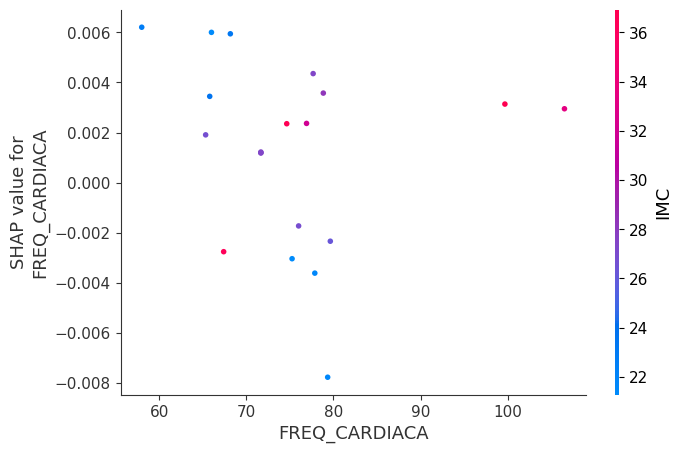

In [32]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Asunciones (Asegúrate de que estas variables existen en tu entorno) ---
# rf_model_regularized: Tu modelo Random Forest ganador
# X_test_scaled: Tu DataFrame de test escalado

# 1. Inicializar el Explainer (para el Random Forest ganador)
explainer = shap.TreeExplainer(rf_model)

# 2. Calcular los SHAP Interaction Values
# Esto puede ser computacionalmente costoso y tomará más tiempo que los SHAP values normales.
print("Calculando SHAP Interaction Values...")
shap_interaction_values = explainer.shap_interaction_values(df_X_test)
print("Cálculo completado.")

# 3. Analizar la Matriz de Interacciones
# La matriz es (muestras, características, características). 
# Calcularemos la media absoluta para encontrar las interacciones promedio más fuertes.

# Obtener los nombres de las columnas
feature_names = df_X_test.columns

# Calcular el valor absoluto medio de la matriz de interacción (promediado sobre todas las muestras)
# La diagonal principal de la matriz contiene los SHAP values principales (efecto propio).
# Fuera de la diagonal contiene los efectos de interacción pura.
mean_interaction = np.abs(shap_interaction_values).mean(0)

# 4. Encontrar la Interacción Global más Fuerte
# Excluir la diagonal (efectos principales)
np.fill_diagonal(mean_interaction, 0) 

# Encontrar los índices de la interacción más fuerte
max_interaction_indices = np.unravel_index(np.argmax(mean_interaction), mean_interaction.shape)

feature_1_idx = max_interaction_indices[0]
feature_2_idx = max_interaction_indices[1]

feature_1_name = feature_names[feature_1_idx]
feature_2_name = feature_names[feature_2_idx]

print(f"\nLa interacción media más fuerte es entre: {feature_1_name} y {feature_2_name}")
print(f"Valor medio de interacción: {mean_interaction[feature_1_idx, feature_2_idx]:.4f}")


# 5. Visualizar la Interacción Más Fuerte
# Usamos el dependence plot con el parámetro interaction_index
print("\nGenerando plot de dependencia para la interacción más fuerte...")

# Crear una matriz vacía con la forma correcta
shap_values_interaction_2d = np.zeros(
    (df_X_test.shape[0], df_X_test.shape[1])
)

# Colocar la interacción en la columna de la feature principal
shap_values_interaction_2d[:, feature_1_idx] = (
    shap_interaction_values[:, feature_1_idx, feature_2_idx]
)

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    ind=feature_1_idx,
    shap_values=shap_values_interaction_2d,
    features=df_X_test,
    interaction_index=feature_2_idx,
    feature_names=feature_names
)

plt.show()


## Métodos Locales (Explicación por Instancia)
### Diverse Counterfactual Explanations (DiCE)

DiCE aborda la pregunta: "¿Cuáles son los cambios mínimos, factibles y diversos en las características de un paciente que habrían llevado al modelo a predecir un INR diferente (un resultado objetivo deseado)?"Esto es crucial para la toma de decisiones clínicas, ya que proporciona escenarios contrafactuales (lo que podría haber sido) accionables.Ejemplo: Si el INR predicho del Paciente A es $3.5$ (riesgo alto), DiCE podría decir:Opción 1: Si su Hematíes hubiera sido $4.2$ (en lugar de $3.5$), el INR predicho sería $2.5$.Opción 2: Si su Frecuencia Cardíaca hubiera sido $65$ (en lugar de $95$), el INR predicho sería $2.4$.

In [33]:
import dice_ml
import warnings
warnings.filterwarnings('ignore', message='X has feature names')
# --- Asumir el Paciente a Explicar (Instancia de interés) ---
# Seleccionamos la primera instancia del set de prueba para el ejemplo.
instance_of_interest = df_X_test.iloc[0:1] 
# El valor de INR real (solo para contexto, DiCE solo usa el modelo)
actual_prediction = rf_model.predict(instance_of_interest)[0]

# --- Definir el Objetivo Deseado ---
# Si la predicción actual es alta (ej. 3.5), queremos encontrar contrafactuales para un INR bajo (ej. 2.5)
target_prediction_value = 2.5 

df_train_dice = df_X_train.copy()
df_train_dice['INR'] = y_train
feature_names = [col for col in df_train_dice.columns if col != 'INR']

# --- Inicializar DiCE ---
# La librería DiCE requiere que le pases el modelo, los datos y los tipos de datos.
d = dice_ml.Data(dataframe=df_train_dice, continuous_features=feature_names, outcome_name='INR')
m = dice_ml.Model(model=rf_model, backend='sklearn', model_type='regressor')
exp = dice_ml.Dice(d, m, method='random') # Método rápido, también se puede usar 'genetic'

# --- Generar Explicaciones Contrafactuales ---
dice_explanation = exp.generate_counterfactuals(
     instance_of_interest, 
     total_CFs=5, # Queremos 3 opciones diferentes
     desired_range=[target_prediction_value - 0.1, target_prediction_value + 0.1]
 )

# 1. Generar el DataFrame de las explicaciones contrafactuales
cf_df = dice_explanation.visualize_as_dataframe()

100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

Query instance (original outcome : 2.0)


,CALCI,HEMOGLOBINA,VCM,HEMATOCRIT,PLAQUETES,IMC,HB_GLICOSILADA_A1C,PES,CRIBRATGE_ALIMENTACIO,MAGNESI,...,NT_PROBNP,CREATINA_KINASA_CK,FREQ_CARDIACA,PCR,HEMATIES,DIAGNOSTIC_ASSOCIAT=EP_Other_No_CorPulm,DIAGNOSTIC_ASSOCIAT=FA_Cron,DIAGNOSTIC_ASSOCIAT=FA_NE,DIAGNOSTIC_ASSOCIAT=Flebitis_Profunda,INR
0,2.19,13.15,92.300003,39.5,206.5,23.799999,6.22,51.599998,1.0,1.83,...,1660.5,63.099998,65.800003,14.63,4.04,1.0,0.0,0.0,0.0,2.0



Diverse Counterfactual set (new outcome: [2.4, 2.6])


,CALCI,HEMOGLOBINA,VCM,HEMATOCRIT,PLAQUETES,IMC,HB_GLICOSILADA_A1C,PES,CRIBRATGE_ALIMENTACIO,MAGNESI,...,NT_PROBNP,CREATINA_KINASA_CK,FREQ_CARDIACA,PCR,HEMATIES,DIAGNOSTIC_ASSOCIAT=EP_Other_No_CorPulm,DIAGNOSTIC_ASSOCIAT=FA_Cron,DIAGNOSTIC_ASSOCIAT=FA_NE,DIAGNOSTIC_ASSOCIAT=Flebitis_Profunda,INR
0,2.19,13.15,92.3,35.35,206.5,23.8,6.22,51.6,1.0,1.83,...,1660.5,63.1,65.8,14.63,4.04,0.6,0.0,0.0,0.0,2.413213
1,2.19,13.15,92.3,43.04,206.5,23.8,6.22,51.6,1.0,1.83,...,1660.5,63.1,65.8,14.63,4.04,1.0,0.0,0.0,1.0,2.403997
2,2.51,13.15,92.3,39.50,206.5,23.8,6.22,51.6,1.0,1.83,...,1660.5,63.1,65.8,14.63,4.04,1.0,0.0,0.0,0.0,2.400921
3,2.19,13.15,92.3,39.50,206.5,23.8,6.22,51.6,1.0,1.83,...,1660.5,63.1,65.8,14.63,4.04,1.0,0.0,0.0,0.0,2.407972
4,2.19,13.15,92.3,39.50,206.5,23.8,6.22,51.6,1.0,1.83,...,1660.5,63.1,65.8,9.68,4.04,1.0,0.0,0.0,1.0,2.409570


### Shapley Additive Explanations (SHAP)

In [34]:
import shap
import pandas as pd
import numpy as np

# --- 1. Inicializar el Explicador SHAP ---
# Para modelos basados en árboles (Random Forest), se usa TreeExplainer, que es muy eficiente.
explainer = shap.TreeExplainer(rf_model)

# --- 2. Calcular Valores SHAP ---
# Calculamos los valores SHAP para todas las instancias en el conjunto de prueba
# (Esto puede tardar un poco dependiendo del tamaño de df_X_test)
shap_values = explainer.shap_values(df_X_test)

# --- 3. Obtener el valor base (Expected Value) ---
# El valor base es la predicción promedio del modelo en el dataset de entrenamiento/background
expected_value = explainer.expected_value

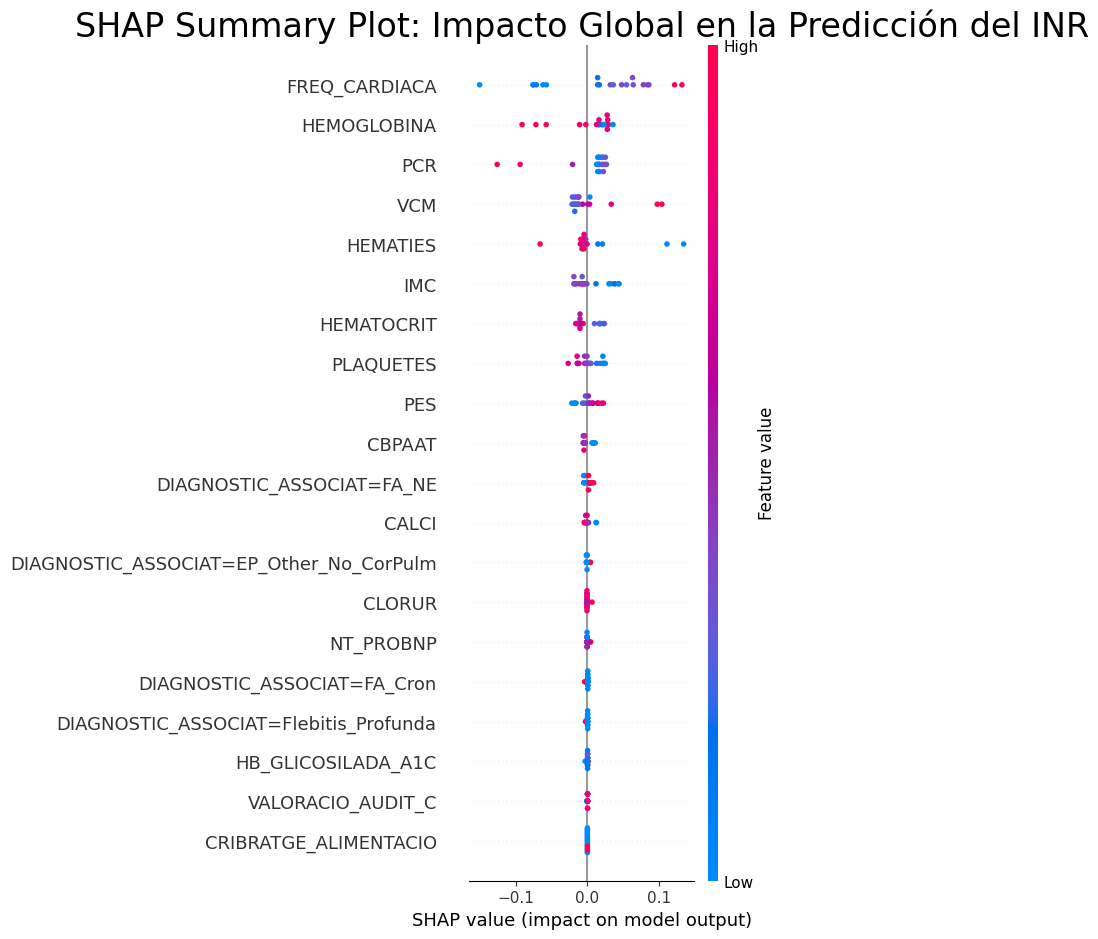

In [35]:
# --- Generar el Summary Plot ---
# Muestra las variables más importantes globalmente
shap.summary_plot(shap_values, df_X_test, show=False)
plt.title("SHAP Summary Plot: Impacto Global en la Predicción del INR")
plt.show()

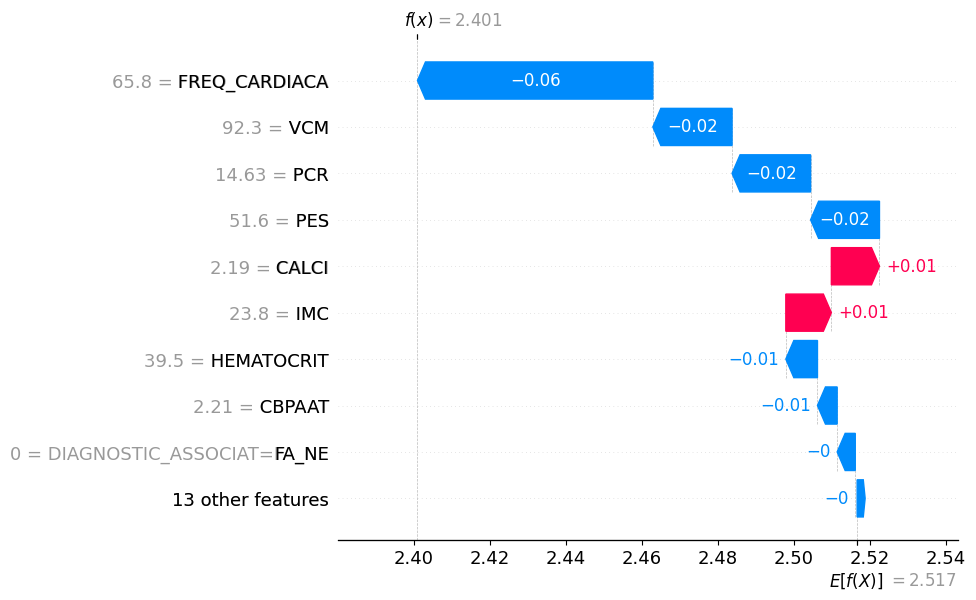

In [36]:
# --- Seleccionar la instancia de interés (fila 0 de df_X_test) ---
instance_index = 0
instance_data = df_X_test.iloc[instance_index]
instance_shap_values = shap_values[instance_index]

# --- Generar el Waterfall Plot ---
# Muestra cómo se construye la predicción final a partir del valor base
shap.plots.waterfall(
    shap.Explanation(
        values=instance_shap_values, 
        base_values=expected_value, 
        data=instance_data, 
        feature_names=df_X_test.columns.tolist()
    ), 
    show=True
)

In [37]:
df_investig_INR.to_csv('data/df_investig_INR.csv')

NameError: name 'df_investig_INR' is not defined